# 勞動力市場對股價行情影響研究 (暫緩-數據缺失or取得不易)

本篇主要觀察勞動力市場對市場行情有沒有影響

勞動力資訊大約可以分成以下幾種 (歡迎補充!)
- 就業人口數據 : 了解就業比例
- 薪資和工資數據 : 了解勞工薪資結構
- 職業結構和行業數據 : 加入行業分類
- 裁員和招聘數據 : 勞動市場變動 -> 缺工 or 不願意上工
- 勞動生產率數據 : 生產力水平

## 台灣就業市場

從[中華民國統計資訊網](https://nstatdb.dgbas.gov.tw/dgbasall/webMain.aspx?sys=100&funid=qryout&funid2=A040107010&outmode=8&ym=10801&ymt=11305&cycle=41&outkind=1&compmode=0&ratenm=%u7D71%u8A08%u503C&fldlst=111111111111&codlst0=100&compmode=0&rr=q10622x&&rdm=R177870)抓取勞動資訊並且處理



In [8]:
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
import pandas as pd
import requests
import json
import re

In [38]:
def get_employment_info(start_year:str, end_year:str) -> pd.DataFrame:
    """Get employment info from 中華民國統計資訊網, and return a dataframe

    Args:
        start_year (str): (ex. 1978)
        end_year (str): (ex. 2024)

    Returns:
        A dataframe of employment info
    """
    
    url = f"https://nstatdb.dgbas.gov.tw/dgbasall/webMain.aspx?sdmx/a040107010/1+2+3+4+5+6+7+8+9+10+11+12.1..M.&startTime={start_year}-M1&endTime={end_year}-M5"
    
    
    res = requests.get(url).json()["data"]
    raw_data = res["dataSets"][0]["series"]
    index = res["structure"]["dimensions"]
    columns_value = index["series"][0]["values"]
    rows_value = index["observation"][0]["values"]
    
    # 加入 column index
    columns = []
    for column in columns_value:
        columns.append(column["name"])
    # 加入 row index
    rows = []
    for row in rows_value:
        date_str = re.sub(r'M(\d{1,2})', lambda x: f'{int(x.group(1)):02d}', row["id"])
        date_obj = datetime.strptime(date_str, "%Y-%m")
        rows.append(date_obj)
    # 加入 data
    table = []
    for i in list(raw_data.keys()):
        col_data = []
        for j in list(raw_data[i]["observations"].keys()):
            col_data.append(raw_data[i]["observations"][j][0])
        table.append(col_data)
    
    # 建立 dataframe
    df = pd.DataFrame(index=rows, columns=columns)
    for i, row in enumerate(table):
        for j, value in enumerate(row):
            df.iat[j, i] = value
    
    return df 

In [81]:
employment = get_employment_info("1978", "2024")
employment.head()

,總人口數(千人),15歲以上民間人口(千人),勞動力(千人),就業人數(千人),失業人數(千人),15歲以上民間人口占總人口數(%),勞動力占總人口數(%),勞動力參與率(%),就業人口占總人口數(%),就業人口占15歲以上民間人口(%),就業人口占勞動力(%),失業率(%)
1978-01-01,16832,10662,6242,6117,125,63.34,37.08,58.54,36.34,57.37,97.99,2.01
1978-02-01,16854,10663,6195,6081,114,63.27,36.76,58.1,36.08,57.03,98.16,1.84
1978-03-01,16884,10706,6175,6066,108,63.41,36.57,57.68,35.93,56.66,98.24,1.76
1978-04-01,16908,10717,6229,6131,98,63.39,36.84,58.12,36.26,57.2,98.42,1.58
1978-05-01,16930,10746,6261,6155,106,63.47,36.98,58.26,36.36,57.28,98.3,1.7


In [82]:
tw_stock = yf.download("^TWII", start='1978-01-01', end=employment.index[-1].strftime('%Y-%m-%d'))
price_pct_groth = tw_stock['Close'].pct_change().fillna(0)
tw_stock["price_cum_growth"] = (1 + price_pct_groth).cumprod() - 1
data_min, data_max = tw_stock["price_cum_growth"].min(), tw_stock["price_cum_growth"].max()
new_min, new_max = 0, 7
tw_stock["price_cum_growth"] = (tw_stock["price_cum_growth"] - data_min) / (data_max - data_min) * (new_max - new_min) + new_min
# 設定數據最早的起始日期
employment = employment[employment.index>=tw_stock.index[0]]

[*********************100%%**********************]  1 of 1 completed


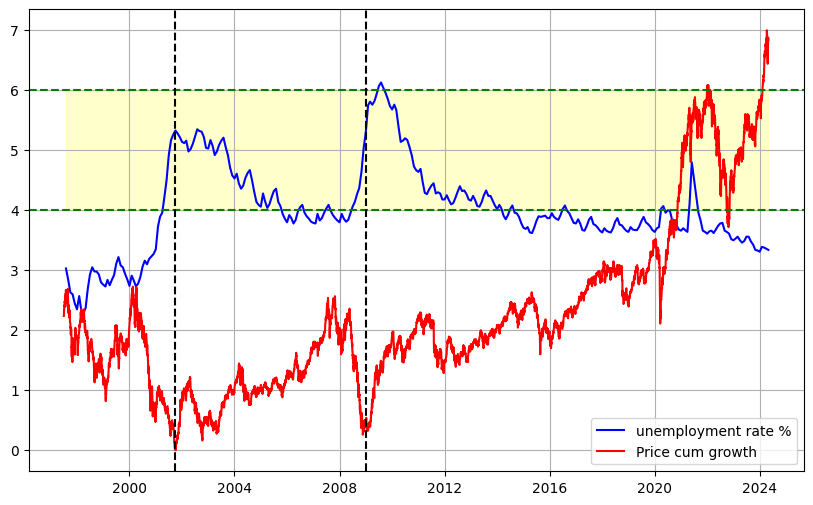

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(employment.index, employment['失業率(%)'], linestyle='-', color='b', label='unemployment rate %')
plt.plot(tw_stock.index, tw_stock["price_cum_growth"] , color='red', label='Price cum growth')
plt.axhline(y=6, color='green', linestyle='--')
plt.axhline(y=4, color='green', linestyle='--')
plt.fill_between(employment.index, 4, 6, color='yellow', alpha=0.2)
plt.axvline(x=pd.Timestamp('2009-01-01 00:00:00'), color='black', linestyle='--')
plt.axvline(x=pd.Timestamp('2001-10-01 00:00:00'), color='black', linestyle='--')
plt.legend()
plt.grid(True)

### 失業率影響
以長期數據來看台灣失業率與經濟呈現相反關係，失業率越高則經濟衰退，符合正常常識，但是失業率數據對市場氛圍存在滯後性，可以很明顯的看出市場價格會率先做出反應後失業率才會跟著輪動

放大來看失業率的小上升下降也沒有很明顯的跟市場行情有關係，因此失業率用來判斷市場價格比較困難，台灣只有在金融危機時才會出現失業率的大幅影響

值得一提的是目前台灣失業率低於正常情況 4~6%，可能出現缺工情況，可觀察招聘數據

## 薪資數據 (暫緩)
觀察薪資成長幅度與市場價格之間的關係
<span style="color: #F85557;"> 目前沒有一個統一的數據庫或是爬蟲展示歷年的薪資中位數和平均數</span>